# ECSE 415 Assignment 2

In [63]:
## Imports ##
import os
import glob
import cv2 as cv
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [64]:
## Path to Images ##
path = './images/A2/'

## Problem 1: Image Stitching
* Displaying gray images
* Visualizing SIFT and Descriptors **(Referenced tutorial 4)**
* Image stitching **(Referenced tutorial 4)**

#### Displaying Grayscale Images

(-0.5, 3023.5, 4031.5, -0.5)

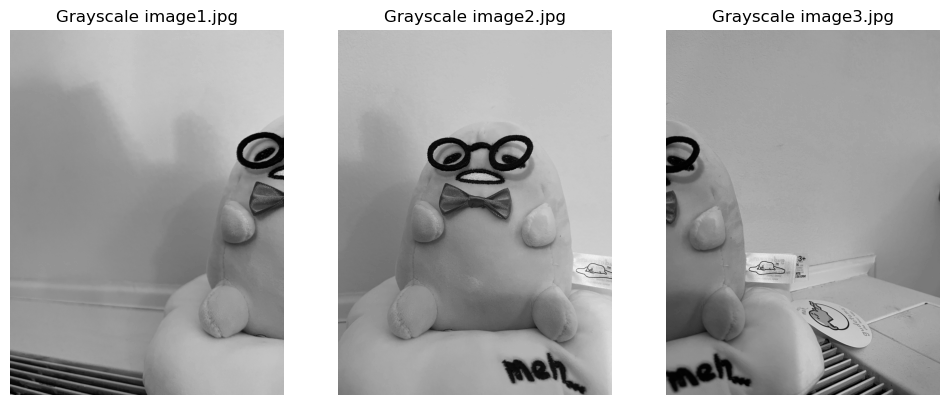

In [65]:
image1 = cv.cvtColor(cv.imread(path + 'image1.jpg'), cv.COLOR_BGR2GRAY)
image2 = cv.cvtColor(cv.imread(path + 'image2.jpg'), cv.COLOR_BGR2GRAY)
image3 = cv.cvtColor(cv.imread(path + 'image3.jpg'), cv.COLOR_BGR2GRAY)

# ## Resize Image ##
# image1 = cv.resize(image1, (192, 256))
# image2 = cv.resize(image2, (192, 256))
# image3 = cv.resize(image3, (192, 256))

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(image1, cmap='gray')
plt.title("Grayscale image1.jpg")
plt.axis('off')

# Gaussian Filtered Image
plt.subplot(1,3,2)
plt.imshow(image2, cmap='gray')
plt.title("Grayscale image2.jpg")
plt.axis('off')

# Median Filtered Image
plt.subplot(1,3,3)
plt.imshow(image3, cmap='gray')
plt.title("Grayscale image3.jpg")
plt.axis('off')

#### Visualize SIFT Keypoints and Descriptors
Visualizing descriptors referenced from tutorial 4

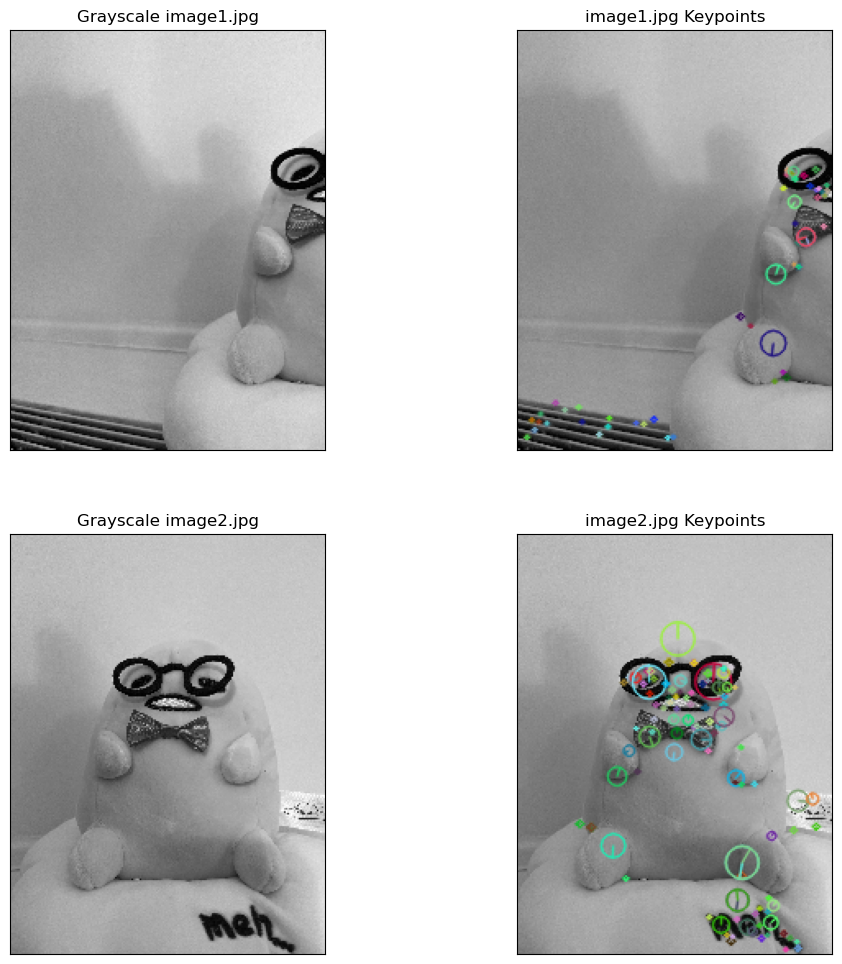

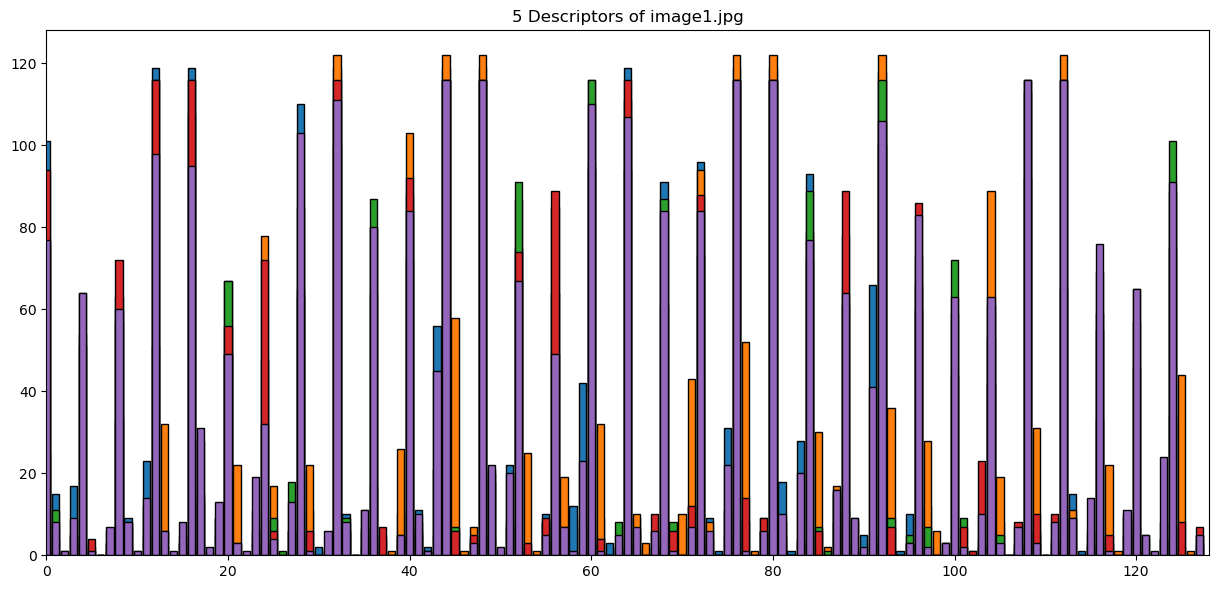

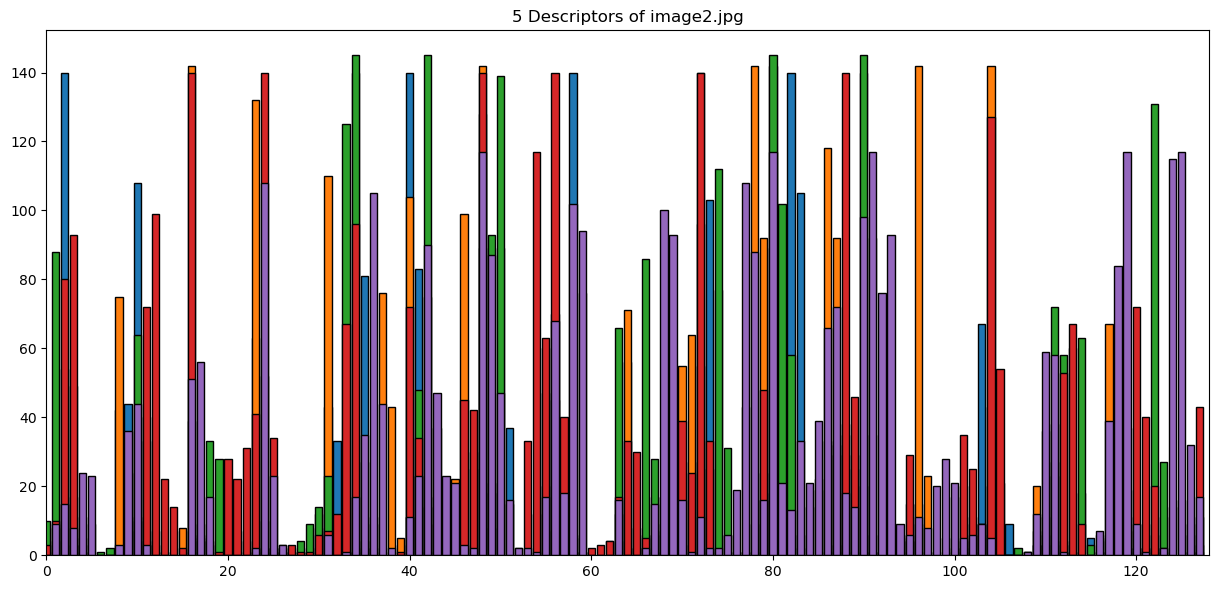

In [66]:
image1 = cv.imread(path + 'image1.jpg')
image2 = cv.imread(path + 'image2.jpg')


## Resize Image ##
image1 = cv.resize(image1, (192, 256))
image2 = cv.resize(image2, (192, 256))


## Create copies of images ##
img1 = image1.copy()
img2 = image2.copy()


## Create SIFT Object and Compute Keypoints and Descriptors ##
sift = cv.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
image2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)


## Visualize Keypoints ##
cv.drawKeypoints(image1, keypoints1, img1, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.drawKeypoints(image2, keypoints2, img2, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(image1, cmap='gray')
plt.title("Grayscale image1.jpg"), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,2)
plt.imshow(img1, cmap='gray')
plt.title("image1.jpg Keypoints"), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,3)
plt.imshow(image2, cmap='gray')
plt.title("Grayscale image2.jpg"), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,4)
plt.imshow(img2, cmap='gray')
plt.title("image2.jpg Keypoints"), plt.xticks([]), plt.yticks([])


## Plot 5 Descriptors ##
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.title('5 Descriptors of image1.jpg')
for i in range(5):
    plt.bar(np.arange(0, 128), descriptors1[i], edgecolor='k')
    plt.xlim([0,128]) # set x-axis limit
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(2,1,2)
plt.title('5 Descriptors of image2.jpg')
for i in range(5):
    plt.bar(np.arange(0, 128), descriptors2[i], edgecolor='k')
    plt.xlim([0,128]) # set x-axis limit
plt.show()

#### Match Top 10 Descriptors

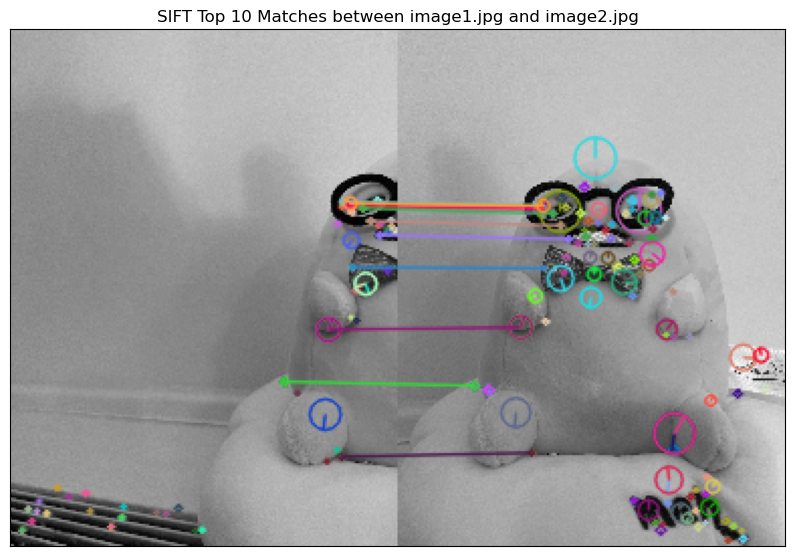

In [67]:
## Create Brute-force Matcher and Match Both Descriptors ##
brute = cv.BFMatcher(cv.NORM_L2, crossCheck=True) # Create the brute-force matcher
matches = brute.match(descriptors1, descriptors2) # Match descriptor with brute-force method
matches = sorted(matches, key = lambda x:x.distance) # Sort the matches based on their distances

## Visualize Matches ##
figure = cv.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Draw the top 10 keypoints as circles with their orientation
plt.figure(figsize=(10,10))
plt.title("SIFT Top 10 Matches between image1.jpg and image2.jpg"), plt.xticks([]), plt.yticks([])
plt.imshow(figure)

### Image Stitching Panorama
Referenced from Tutorial 4 and https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
* RANSAC Homography matrix
* Apply transformation
* Pyramid Blending (https://docs.opencv.org/4.x/dc/dff/tutorial_py_pyramids.html)
* Linear Blending

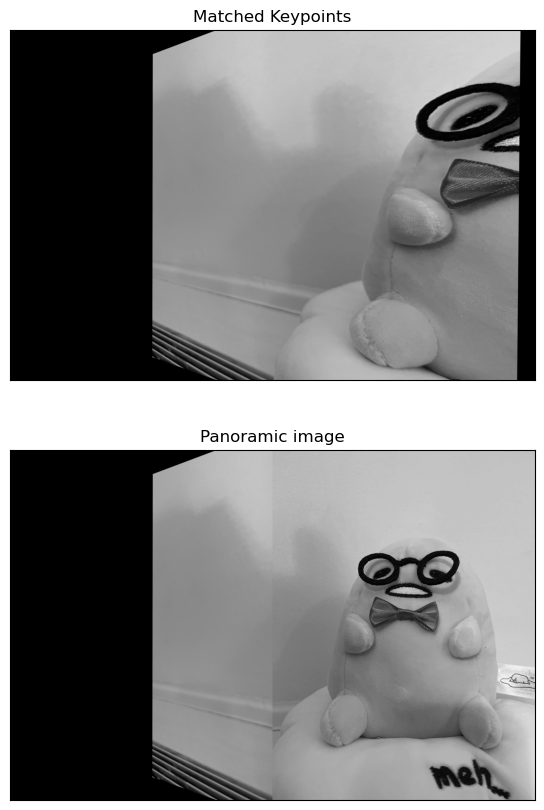

In [68]:
## Reading Image for Stitching
imgl = cv.imread(path+'image1.jpg')
imgr = cv.imread(path+'image2.jpg')

imgl = cv.cvtColor(imgl, cv.COLOR_BGR2RGB)
imgr = cv.cvtColor(imgr, cv.COLOR_BGR2RGB)


## Compute keypoints and descriptors ##
sift = cv.SIFT_create()
keypoints_l, descriptors_l = sift.detectAndCompute(imgl, None)
keypoints_r, descriptors_r = sift.detectAndCompute(imgr, None)


## Create Matches ##
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
# Match descriptors.
matches = bf.match(descriptors_r, descriptors_l) # query image, train image
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 1000:
        GoodMatches.append((m.trainIdx, m.queryIdx))

mpr = np.float32([keypoints_r[i].pt for (__, i) in GoodMatches])
mpl = np.float32([keypoints_l[i].pt for (i, __) in GoodMatches])


## RANSAC Homography ##
H, _ = cv.findHomography(mpr, mpl, cv.RANSAC, 4)


## Apply Transformation ##
wimg = cv.warpPerspective(imgl, H, (imgr.shape[1]+imgl.shape[1], imgr.shape[0]))
# make a copy of the gray version to facilitate later parts
wimg_gray = cv.cvtColor(wimg, cv.COLOR_RGB2GRAY) 
imgr_gray = cv.cvtColor(imgr, cv.COLOR_RGB2GRAY) 


## Plot Warped Image ##
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.imshow(wimg_gray, cmap='gray')
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])

wimg_color = wimg.copy()

## Stitch Image Together ##
wimg_color[:imgl.shape[0],imgl.shape[1]:,:] = imgr
wimg_gray[:imgl.shape[0],imgl.shape[1]:] = imgr_gray

plt.subplot(2,1,2)
plt.imshow(wimg_gray, cmap='gray')
plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
plt.show()

#### Pyramid Blending
I attempted to Pyramid blend but don't know how I can upscale the image. Sorry, this is just to show that I tried still. The following code I willuse the unblended version.
https://docs.opencv.org/4.x/dc/dff/tutorial_py_pyramids.html

(Text(0.5, 1.0, 'Pyramid Blending'), ([], []), ([], []))

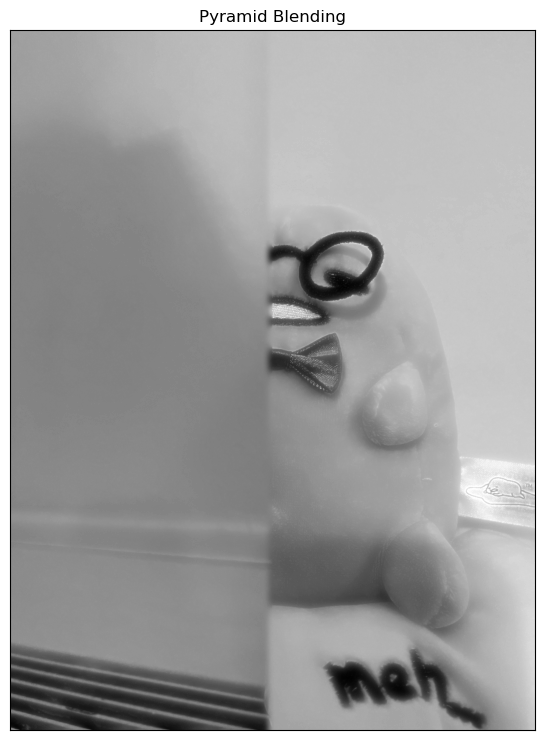

In [69]:
G = cv.cvtColor(imgl, cv.COLOR_BGR2GRAY).copy()
gpA = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpA.append(G)
 
# generate Gaussian pyramid for B
G = imgr_gray.copy()
gpB = [G]
for i in range(6):
    G = cv.pyrDown(G)
    gpB.append(G)
 
# generate Laplacian Pyramid for A
lpA = [gpA[5]]
for i in range(5,0,-1):
    GE = cv.pyrUp(gpA[i], dstsize=(gpA[i-1].shape[1], gpA[i-1].shape[0]))
    L = cv.subtract(gpA[i-1],GE)
    lpA.append(L)
 
# generate Laplacian Pyramid for B
lpB = [gpB[5]]
for i in range(5,0,-1):
    GE = cv.pyrUp(gpB[i], dstsize=(gpB[i-1].shape[1], gpB[i-1].shape[0]))
    L = cv.subtract(gpB[i-1],GE)
    lpB.append(L)
 
# Now add left and right halves of images in each level
LS = []
for la,lb in zip(lpA,lpB):
    rows,cols = la.shape
    ls = np.hstack((la[:,0:cols//2], lb[:,cols//2:]))
    LS.append(ls)
 
# now reconstruct
ls_ = LS[0]
for i in range(1,6):
    ls_ = cv.pyrUp(ls_, dstsize=(LS[i].shape[1], LS[i].shape[0]))
    ls_ = cv.add(ls_, LS[i])
 

plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.imshow(ls_, cmap='gray')
plt.title("Pyramid Blending"), plt.xticks([]), plt.yticks([])

### Merging image12 with image3
* Visualizing SIFT keypoints and descriptors
* Matching top 10 descriptors
* RANSAC Homography matrix
* Apply transformation
* Image Stitching

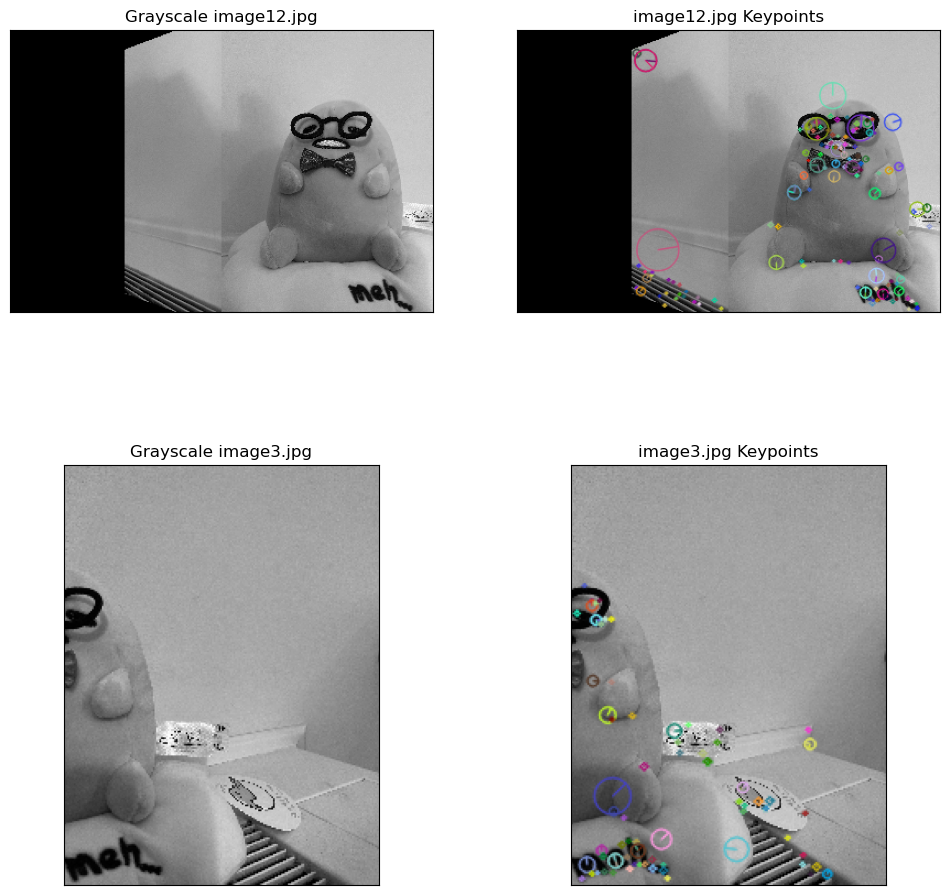

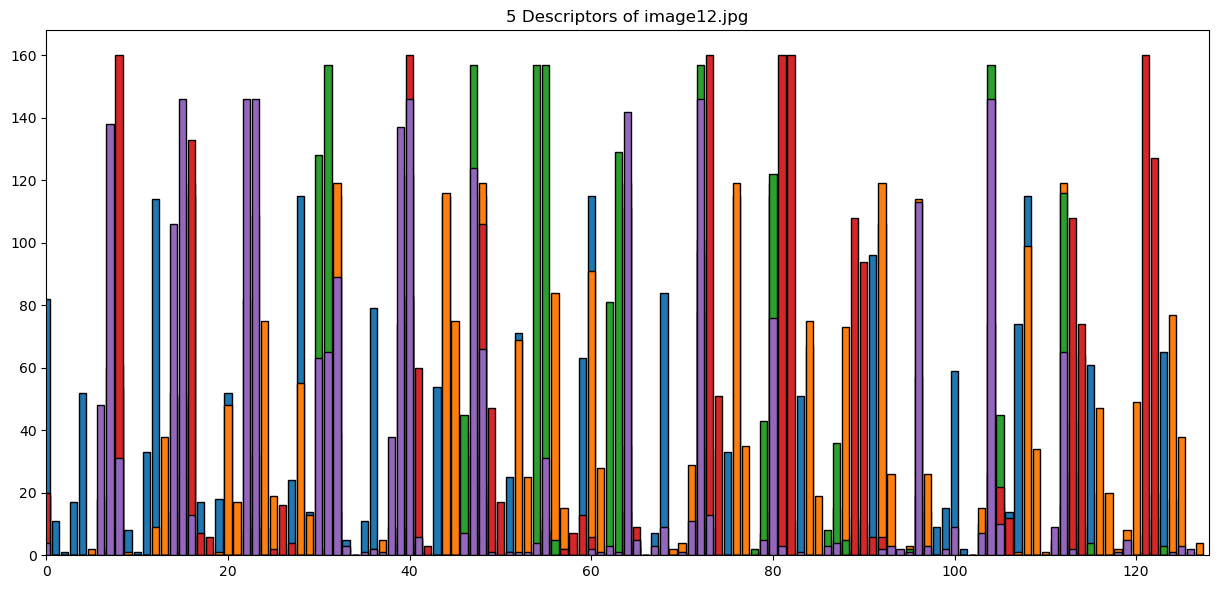

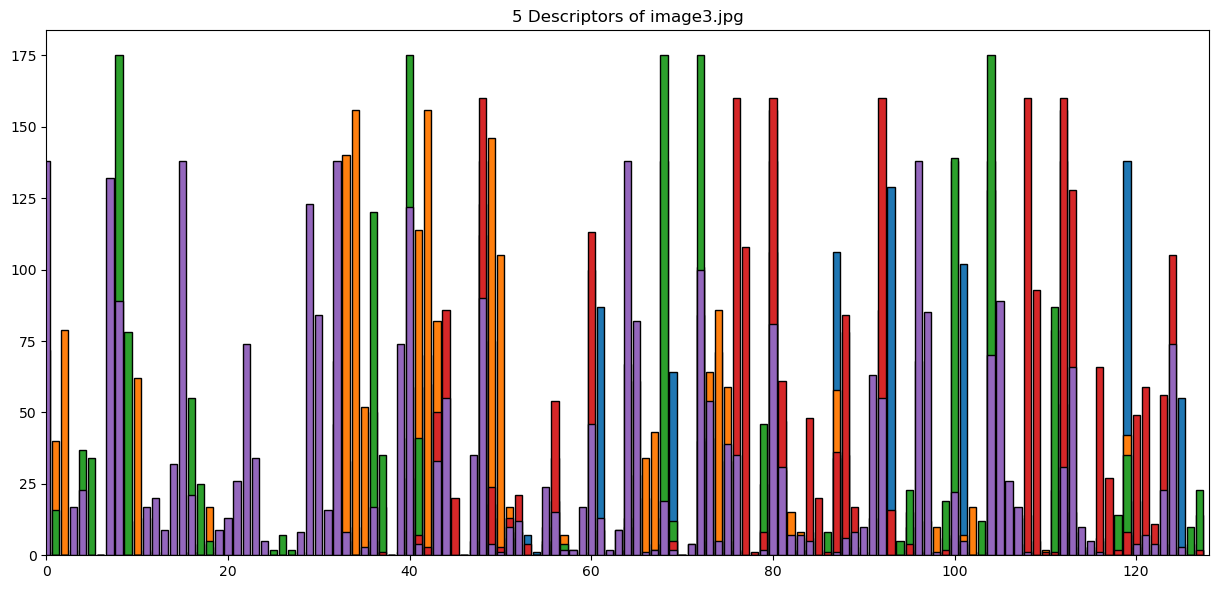

In [70]:
image12 = wimg_color
image3 = cv.imread(path + 'image3.jpg')

## Resize Image ##
image12 = cv.resize(image12, (384, 256))
image3 = cv.resize(image3, (192, 256))


## Create copies of images ##
img12 = image12.copy()
img3 = image3.copy()


## Create SIFT Object and Compute Keypoints and Descriptors ##
sift = cv.SIFT_create()
keypoints12, descriptors12 = sift.detectAndCompute(image12, None)
keypoints3, descriptors3 = sift.detectAndCompute(image3, None)

image12 = cv.cvtColor(image12, cv.COLOR_BGR2GRAY)
image3 = cv.cvtColor(image3, cv.COLOR_BGR2GRAY)


## Visualize Keypoints ##
cv.drawKeypoints(image12, keypoints12, img12, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.drawKeypoints(image3, keypoints3, img3, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(image12, cmap='gray')
plt.title("Grayscale image12.jpg"), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,2)
plt.imshow(img12, cmap='gray')
plt.title("image12.jpg Keypoints"), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,3)
plt.imshow(image3, cmap='gray')
plt.title("Grayscale image3.jpg"), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,4)
plt.imshow(img3, cmap='gray')
plt.title("image3.jpg Keypoints"), plt.xticks([]), plt.yticks([])


## Plot 5 Descriptors ##
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.title('5 Descriptors of image12.jpg')
for i in range(5):
    plt.bar(np.arange(0, 128), descriptors12[i], edgecolor='k')
    plt.xlim([0,128]) # set x-axis limit
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(2,1,2)
plt.title('5 Descriptors of image3.jpg')
for i in range(5):
    plt.bar(np.arange(0, 128), descriptors3[i], edgecolor='k')
    plt.xlim([0,128]) # set x-axis limit
plt.show()

#### Top 10 Matches

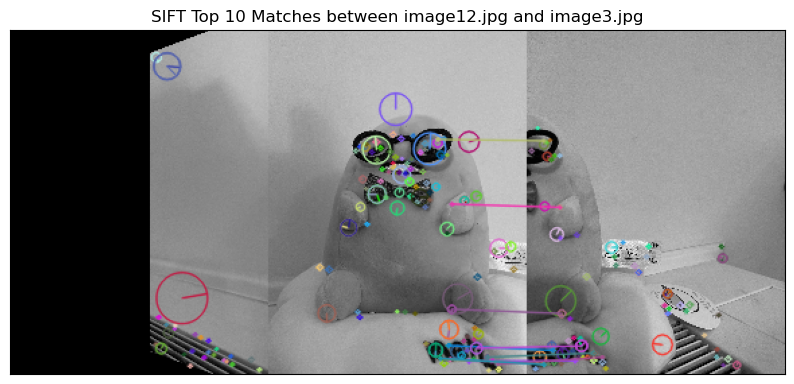

In [71]:
## Create Brute-force Matcher and Match Both Descriptors ##
brute = cv.BFMatcher(cv.NORM_L2, crossCheck=True) # Create the brute-force matcher
matches = brute.match(descriptors12, descriptors3) # Match descriptor with brute-force method
matches = sorted(matches, key = lambda x:x.distance) # Sort the matches based on their distances

## Visualize Matches ##
figure = cv.drawMatches(image12, keypoints12, image3, keypoints3, matches[:10], None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Draw the top 10 keypoints as circles with their orientation
plt.figure(figsize=(10,10))
plt.title("SIFT Top 10 Matches between image12.jpg and image3.jpg"), plt.xticks([]), plt.yticks([])
plt.imshow(figure)

Attempted to do homography...

(4032, 6048)


(Text(0.5, 1.0, 'Matched Keypoints'), ([], []), ([], []))

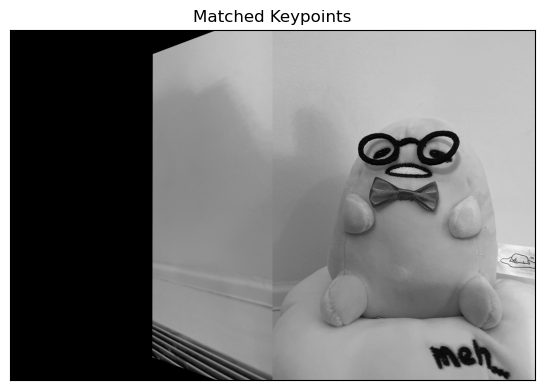

In [72]:
## Reading Image for Stitching
imgr = cv.imread(path+'image3.jpg')

imgl = cv.cvtColor(wimg_color, cv.COLOR_BGR2RGB)
imgr = cv.cvtColor(imgr, cv.COLOR_BGR2RGB)


## Compute keypoints and descriptors ##
sift = cv.SIFT_create()
keypoints_l, descriptors_l = sift.detectAndCompute(imgl, None)
keypoints_r, descriptors_r = sift.detectAndCompute(imgr, None)

## Create Matches ##
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
# Match descriptors.
matches = bf.match(descriptors_r, descriptors_l) # query image, train image
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 1000:
        GoodMatches.append((m.trainIdx, m.queryIdx))

mpr = np.float32([keypoints_r[i].pt for (__, i) in GoodMatches])
mpl = np.float32([keypoints_l[i].pt for (i, __) in GoodMatches])


## RANSAC Homography ##
H, _ = cv.findHomography(mpl, mpr, cv.RANSAC, 4)


## Apply Transformation ##
wim = cv.warpPerspective(imgr, H, (imgl.shape[1]+imgr.shape[1], imgl.shape[0]))
# make a copy of the gray version to facilitate later parts
wim_gray = cv.cvtColor(wim, cv.COLOR_RGB2GRAY) 
imgl_gray = cv.cvtColor(imgl, cv.COLOR_RGB2GRAY) 

print(wimg_gray.shape)
## Plot Warped Image ##
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.imshow(wimg_gray, cmap='gray')
plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])


# # Stitch Image Together ##
# imgl_gray[:imgl_gray.shape[0],imgl_gray.shape[1]:] = wim_gray

# plt.subplot(2,1,2)
# plt.imshow(wim_gray, cmap='gray')
# plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
# plt.show()

#### Linear Blending
Same as above, can't finish on time so this is just to show I've thought of it

In [73]:
## do a ramp

 ## Answers to Questions

1.   How effective were SIFT keypoints in matching the images? Did you encounter mismatches of keypoints?

*   The SIFT keypoints were not 100% accurate in matching the images. By visual inspection, there were about 3 to 4 mismatches for every pair of pictures we've tested.
---

2.   Compare the results of pyramid blending and linear blending. Which produced better results and why?

*   Technically, pyramid blending is better because it allows a more seamless transition between images by using Laplacian pyramid (separately managing different levels). By considering different levels and blend at different levels, it allows more seamless transition between edges. Linear blending only uses a weighted average between the two images, so it would be overlaid and most of the time not blended

## Problem 2: Face Detection
* Displaying gray images
* Implementing PCA from Scratch
* Projecting Muffin Images
* Computing Euclidean Distances

#### Display Grayscale Images

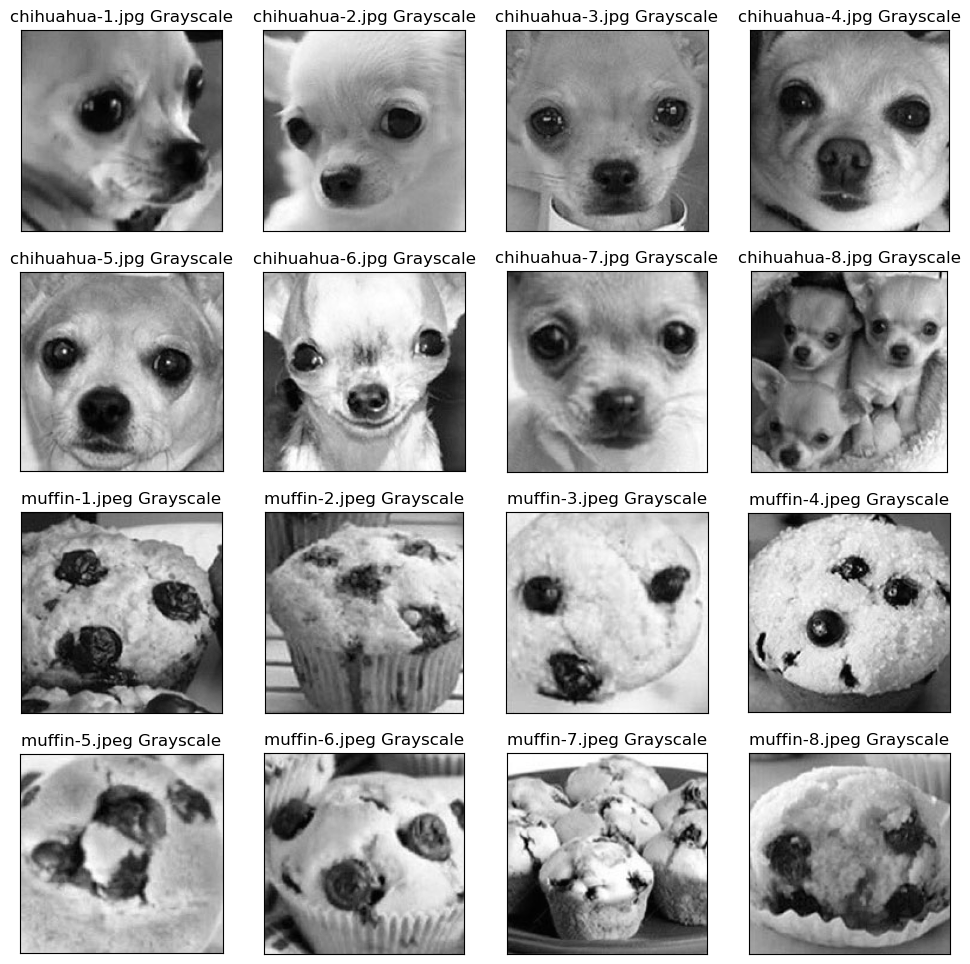

In [74]:
Q2_path = os.path.join(path, 'Q2')
dir = os.listdir(Q2_path)

plt.figure(figsize=(12, 12))
for idx, i in enumerate(dir):
    plt.subplot(4, 4, idx+1)
    img = cv.cvtColor(cv.imread(os.path.join(Q2_path, i)), cv.COLOR_BGR2GRAY)
    plt.imshow(img, cmap='gray')
    plt.title(f'{i} Grayscale'), plt.xticks([]), plt.yticks([])

#### Compute Mean Face

(Text(0.5, 1.0, 'Mean Face of Chihuahua'), ([], []), ([], []))

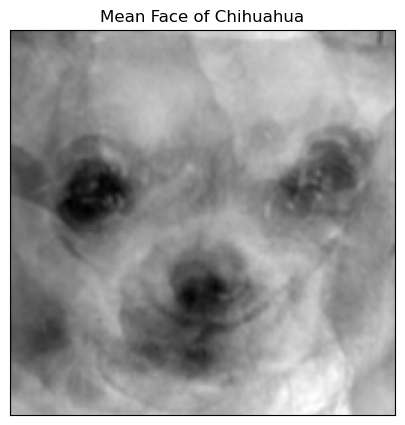

In [75]:
Q2_path = os.path.join(path, 'Q2')
dir = glob.glob(os.path.join(Q2_path,'*.jpg'))

# All images are not the same size, so mean face will be the size of the smallest dimension
chihuahua = []

# Populate mean face vector
for file in dir:
    img = cv.cvtColor(cv.imread(file), cv.COLOR_BGR2GRAY)
    img = cv.resize(img, (168,168))
    chihuahua.append(img)

mean_face = np.mean(chihuahua, axis=0)

plt.figure(figsize=(5,5))
plt.imshow(mean_face, cmap='gray')
plt.title('Mean Face of Chihuahua'), plt.xticks([]), plt.yticks([])

### Implement PCA
* Obtaining eigenvector
* Determining number of principal components
* Determining Reconstruction Error
* Projecting muffin images
* Calculating Euclidean Distance between projected images and Chihuahua Mean Face

#### Obtaining Eigenvector
Using Snapshot method taught in class
* $D:$ Data vector
* $DD^T:$ Convariance Matrix $(C')$
* $v':$ Eigenvectors of C'
* $v:$ Eigenvectors of C $(v = \frac{1}{\lambda}D^Tv')$

(Text(0.5, 1.0, 'Eigenvector of Covariance Matrix from Chihuahua Faces'),
 ([], []),
 ([], []))

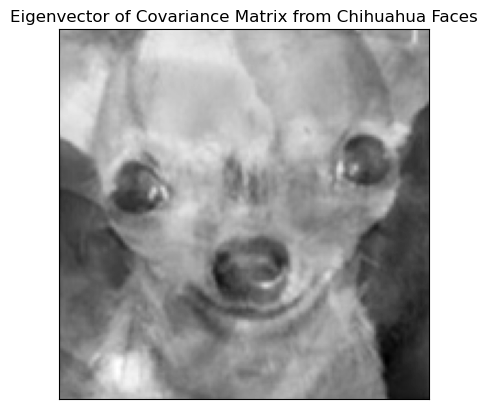

In [76]:
def eigen(imgs, mean):
    ## Find Symmetric Covariance Matrix ##
    D = np.array([(X.flatten() - mean.flatten()) for X in imgs]) # removing mean face from each img vector
    C = D @ D.T
    
    ## Find Eigenvalues and Eigenvectors ##
    eigen_val, eigen_vec_org = np.linalg.eigh(C)
    eigen_vec = 1 / (eigen_val) * np.dot(D.T, eigen_vec_org)
    
    # Sort eigenvalues in descending order
    eigen_val = np.flip(eigen_val, axis=0)
    eigen_vec = np.flip(eigen_vec, axis=1) # Now we can flip the eigenvector to be descending too

    return eigen_val, eigen_vec

eigen_val, eigen_vec = eigen(chihuahua, mean=mean_face)

plt.imshow(np.reshape(eigen_vec[:, 0], (168, 168)), cmap='gray')
plt.title('Eigenvector of Covariance Matrix from Chihuahua Faces'), plt.xticks([]), plt.yticks([])
# pca.fit(dir)

#### Determine Number of Principal Components Needeed
Explained Variance measures the proportion to which a model accounts for the variation of a given data set.
$$ Explained Variance = \frac{\lambda_i}{\sum_{n=1}^{n} \lambda_i}$$

In [77]:
counter_90 = 0
counter_95 = 0

for i in range(eigen_val.shape[0]):
    var = np.sum(eigen_val[0:i]) / np.sum(eigen_val)
    # Check if explained val is greater than 90% or 95%
    if var<=0.95:
        counter_95+=1
        if var<=0.9:
            counter_90+=1

print('the number of principal components needed to explain 90% of the total variance in the data is', counter_90)
print('the number of principal components needed to explain 95% of the total variance in the data is', counter_95)

# Reconstruction Error calculated below

the number of principal components needed to explain 90% of the total variance in the data is 6
the number of principal components needed to explain 95% of the total variance in the data is 7


#### Projection of Muffin Images

#### Reconstruction Error of Chihuahua Images with PCs that Explain 90% and 95% Variances

Text(0.5, 0.98, 'Original Chihuahua, Reconstructions, and Reconstruction Error with PCs that Explain 95% Variances')

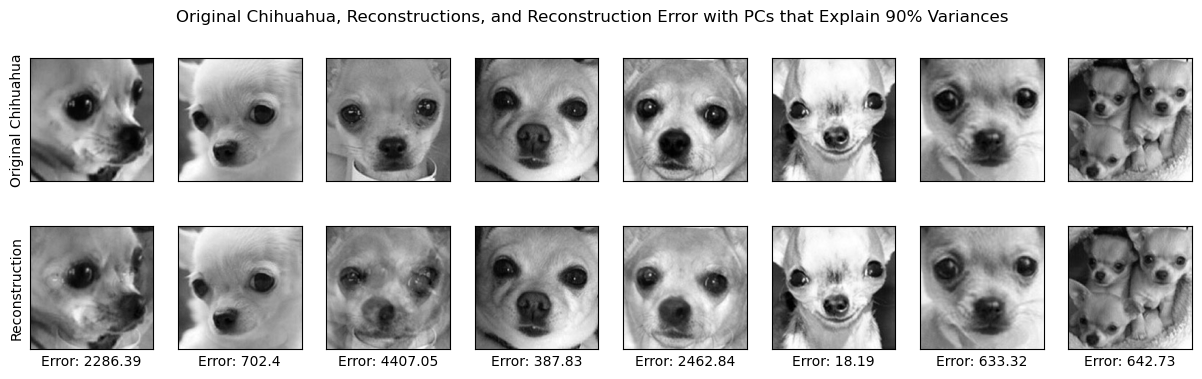

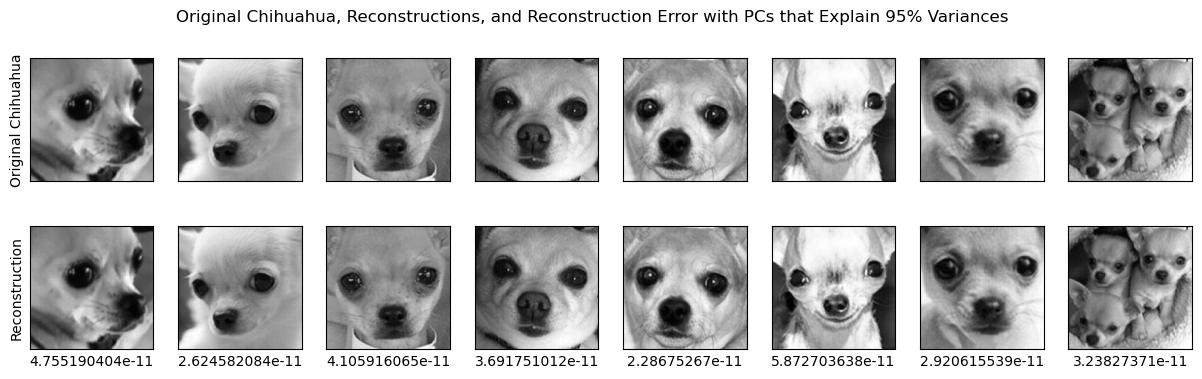

In [78]:
top_eigen90 = eigen_vec[:,:counter_90] / np.linalg.norm(eigen_vec[:, :counter_90], ord=2, axis=0) # Normalization top PCs
top_eigen95 = eigen_vec[:,:counter_95] / np.linalg.norm(eigen_vec[:, :counter_95], ord=2, axis=0) # Normalization top PCs

## 90% ##
fig, ax = plt.subplots(2, len(chihuahua), figsize=(15, 4))
for i in range(len(chihuahua)):
    projection = np.dot(top_eigen90.T, chihuahua[i].flatten() - mean_face.flatten())
    reconstruction  = mean_face.flatten() + np.dot(top_eigen90, projection)
    # Use Euclidean Distance as Reconstruction Error
    error = np.sqrt(np.sum(np.square(chihuahua[i].flatten() - reconstruction)))

    ## Plot Figures ##
    ax[0,i].imshow(chihuahua[i], cmap='gray')
    ax[1,i].imshow(np.reshape(reconstruction, (168, 168)), cmap='gray')
    ax[0,i].set_xticks([])
    ax[1,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_yticks([])
    ax[1,i].set_xlabel(f'Error: {round(error, 2)}')

ax[0,0].set_ylabel("Original Chihuahua")
ax[1,0].set_ylabel("Reconstruction")
fig.suptitle("Original Chihuahua, Reconstructions, and Reconstruction Error with PCs that Explain 90% Variances"), 


## 95% ##
fig, ax = plt.subplots(2, len(chihuahua), figsize=(15, 4))
for j in range(len(chihuahua)):
    projection = np.dot(top_eigen95.T, chihuahua[j].flatten() - mean_face.flatten())
    reconstruction  = mean_face.flatten() + np.dot(top_eigen95, projection)
    # Use Euclidean Distance as Reconstruction Error
    error = np.sqrt(np.sum(np.square(chihuahua[j].flatten() - reconstruction)))

    ## Plot Figures ##
    ax[0,j].imshow(chihuahua[j], cmap='gray')
    ax[1,j].imshow(np.reshape(reconstruction, (168, 168)), cmap='gray')
    ax[0,j].set_xticks([])
    ax[1,j].set_xticks([])
    ax[0,j].set_yticks([])
    ax[1,j].set_yticks([])
    ax[1,j].set_xlabel(round(error, 20))

ax[0,0].set_ylabel("Original Chihuahua")
ax[1,0].set_ylabel("Reconstruction")
fig.suptitle("Original Chihuahua, Reconstructions, and Reconstruction Error with PCs that Explain 95% Variances")

# Discussion Below

In [79]:
dir = glob.glob(os.path.join(Q2_path,'*.jpeg'))

# All images are not the same size, so mean face will be the size of the smallest dimension
muffin = []

# Populate mean face vector
for file in dir:
    img = cv.cvtColor(cv.imread(file), cv.COLOR_BGR2GRAY)
    img = cv.resize(img, (168,168))
    muffin.append(img)

In [80]:
top_eigen90 = eigen_vec[:,:counter_90] / np.linalg.norm(eigen_vec[:, :counter_90], ord=2, axis=0) # Normalization top PCs

## Projection by Dot Product ##
reconstructions = []
for img in muffin:
    projection = np.dot(top_eigen90.T, img.flatten() - mean_face.flatten()) # project onto top k eigenvectors by taking dot product
    reconstructions.append(mean_face.flatten() + np.dot(top_eigen90, projection))


#### Calculate Euclidean Distance Between Muffin and Reconstruction

(Text(0.5, 0.98, 'Original Muffins, Reconstructions, and Euclidean Distance Between the two (In Ascending Order)'),)

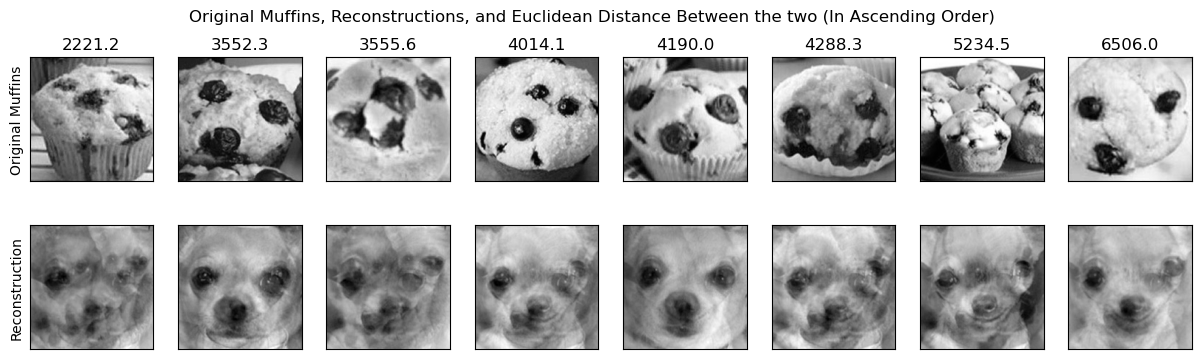

In [81]:
## Calculating Euclidean Distance ##
dist = []
for i in range(len(muffin)):
    dist.append(np.sqrt(np.sum(np.square(mean_face.flatten() - reconstructions[i]))))

# Sort images by euclidean distances
indices = np.argsort(dist)
dist = [dist[i] for i in indices] 
muffin = [muffin[i] for i in indices] 
reconstructions = [reconstructions[i] for i in indices] 


## Plot Results ##
fig, ax = plt.subplots(2, len(muffin), figsize=(15, 4))
for i in range(len(muffin)):
    ax[0,i].imshow(muffin[i], cmap='gray')
    ax[1,i].imshow(np.reshape(reconstructions[i], (168, 168)), cmap='gray')
    ax[0,i].set_xticks([])
    ax[1,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_yticks([])

    ax[0,i].set_title(round(dist[i], 1))

ax[0,0].set_ylabel("Original Muffins")
ax[1,0].set_ylabel("Reconstruction")
fig.suptitle("Original Muffins, Reconstructions, and Euclidean Distance Between the two (In Ascending Order)"), 


## Answers to Questions
1.   Report the number of PCs and use them to compute the reconstruction errors. Discuss the results.

*   the number of principal components needed to explain 90% of the total variance in the data is 6, and the number of principal components needed to explain 95% of the total variance in the data is 7. The reconstruction with the principal components needed to explain 95% of the total variance is better, which is expected because more variance in the dataset is addressed.

---

2.   Discuss the Chihuahua detector’s accuracy and limitations. Identify which muffin image
was the most confusing and hypothesize why

*   Chihuahua Detector is accurate with Images that have clear distinction between chihuahua and non-chihuahua images. However, it does not perform great when the non-chihuahua image looks like chihuahua. muffin-3.jpeg was the most confusing to the detector since its euclidean distance was the largest. We can see why visually: the muffin looks like a dog's face.

## Problem 3: Classifiers
* Resizing Images
* Extracting HoG Features **(referenced tutorial 6)**

#### Resize Images

In [82]:
IMG_SHAPE = (128, 128)

In [83]:
Q3_path = os.path.join(path, 'Q3')

samples = {'test': [], 'train': []} # Dictionary for storing easily accessible data

for pokemon in os.listdir(Q3_path):
    for test_or_train in os.listdir(os.path.join(Q3_path, pokemon)):
        for file in os.listdir(os.path.join(Q3_path, pokemon, test_or_train)):
            img = cv.resize(cv.imread(os.path.join(Q3_path, pokemon, test_or_train, file)), (IMG_SHAPE))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            samples[test_or_train].append({'label': pokemon, 'img': img, 'img_gray': img_gray})

#### HoG Feature Extraction for both Training and Testing Images

In [84]:
img_size = IMG_SHAPE # h x w in pixels
cell_size = (8, 8)
block_size = (2, 2)
nbins = 9  # number of orientation bins

# create HoG Object
hog = cv.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                  img_size[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins,
                        _histogramNormType= cv.NORM_L2)


## Compute Features ##
for test_or_train in samples.values():
    for sample in test_or_train:
        # Hog Features
        sample['hog'] = hog.compute(sample['img_gray'].astype(np.uint8))
        sample['hog'] = sample['hog'] / np.linalg.norm(sample['hog'], ord=2) # L2 Normalization

        # RGB Features
        for i, channel in enumerate(['r','g','b']):
            sample[channel] = cv.calcHist(images=sample['img'], channels=[i], mask=None, histSize=[32], ranges=[0, 256]).squeeze()
            sample[channel] = sample[channel] / np.linalg.norm(sample[channel], ord=1) # L1 Normalization

        # Concatenate all features
        sample['feature'] = np.concatenate((sample['hog'], sample['r'], sample['g'], sample['b']))

#### SVM Classifiers

In [85]:
max_iter = 1000

## Compile Train Data ##
train_X = np.array([sample['feature'] for sample in samples['train']])
train_Y = np.array([sample['label'] for sample in samples['train']])


## Define SVM models ##
model1 = svm.SVC(kernel='linear', C=1.0)
model2 = svm.SVC(kernel='rbf', gamma=4, C=1.0, max_iter=max_iter)
model3 = svm.SVC(kernel='rbf', gamma=6, C=1.0, max_iter=max_iter)
model4 = svm.SVC(kernel='poly', degree=2,C=1.0, max_iter=max_iter)
model5 = svm.SVC(kernel='poly', degree=3, C=1.0, max_iter=max_iter)


## Fit Models ##
models = []
model1.fit(train_X, train_Y)
model2.fit(train_X, train_Y)
model3.fit(train_X, train_Y)
model4.fit(train_X, train_Y)
model5.fit(train_X, train_Y)
models.append(model1)
models.append(model2)
models.append(model3)
models.append(model4)
models.append(model5)


#### Testing and Visualization

The accuracy of model1 is 0.44
The accuracy of model2 is 0.56
The accuracy of model3 is 0.56
The accuracy of model4 is 0.52
The accuracy of model5 is 0.56
Model 1 is linear SVM, Model 2-3 are RBF Kernels, Model 4-5 are polynomial kernels
Darker colors indicate a worse classification and lighter colors indicate a better classification


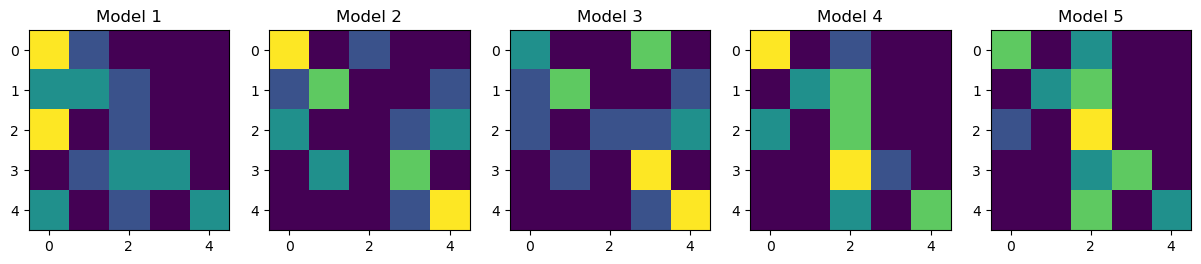

In [86]:
## Compile Test Data ##
test_X  = np.array([sample['feature'] for sample in samples['test']])
test_Y  = np.array([sample['label'] for sample in samples['test']])


## Calculate Accuracy & Confusion Matrix ##
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, model in enumerate(models):
    y_Pred = model.predict(test_X)
    accuracy = accuracy_score(y_Pred, test_Y)
    confuse = confusion_matrix(test_Y, y_Pred, labels=['Bulbasaur', 'Charizard', 'Dragonite', 'Pikachu', 'Squirtle'])
    
    # Visualization
    ax[i].imshow(confuse)
    ax[i].set_title(f"Model {i+1}")
    print(f'The accuracy of model{i+1} is {accuracy}')
print('Model 1 is linear SVM, Model 2-3 are RBF Kernels, Model 4-5 are polynomial kernels')
print('Darker colors indicate a worse classification and lighter colors indicate a better classification')

In [87]:
np.unique(test_Y)

array(['Bulbasaur', 'Charizard', 'Dragonite', 'Pikachu', 'Squirtle'],
      dtype='<U9')

## Answers to Questions
1.   Which kernel provided the best results, and what were the optimal hyperparameters?

*   From the accuracy measurements, RBF kernels performed the best out of the all of the kernels used with the highest overall accuracy. The optimal gamma is any integer between 4-6. Although, C=1.0 is required for this problem, I noticed that increasing the C can improve the result slightly.

---

2.   How did the choice of kernel affect the classification accuracy?

*   As mentioned before, RBF kernel gave the best overall accuracy, defined as the ratio of correct predictions to total predictions. However, the accuracies are pretty close, so we shift our gaze at the confusion matrix. If we look at the confusion matrix, defined as a matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class, we can see that each kernel classified different classes better. This could be due to the non-linearity of some of the sample distributions.  For example, as seen in the confusion matrix, model 2 classifies the third class, Dragonite, horribly; however, model 5 classifies it nicely. Since model 5 is a 3-degree polynomial kernel, this may suggest that the class Dragonite follows a trend that cannot be separated by a radial basis function. Overall, each classifier has its own "best-classifying" class due to irregularities in sample distribution.

---

3.   What challenges did you encounter in classifying the Pokémon images, and how might these challenges be addressed?

*   As seen earlier, all Pokemon images cannot be classified by a single classifier due to different trends in sample distribution. Perhaps an ensemble classifier would be better since it utilizes multiple classifiers; however, for best accuracy, machine learning algorithms such as CNN may produce the best result due to its adaptability and learning ability.

---

4.   Which two Pokémon were most frequently misclassified, and why do you think they were difficult to distinguish?

*   From visually inspecting the confusion matrix, Charizard and Dragonite were the most frequently misclassified classes. From looking at the training images, the two are strikingly similar in color, morphology, features (e.g. wings, tail, paws). Perhaps the classifiers were classifying with these features, in that case it is not surprising they are difficult to distinguish.